## 課題1（Jobshop）: FCFS と OR-Tools 最適化の比較（実行用ノートブック）

このノートブックは、READMEの課題1を **再現可能** に実行して、
- FCFS（先着順）
- OR-Tools（メイクスパン最小）
- OR-Tools（重み付き完了時刻和最小：3パターン）
- 自作ジョブ
の結果（表・ガントチャート）を生成します。

### 事前準備
- Python 3.10+ 推奨
- 依存関係: `requirements.txt`

In [3]:
import simpy
from ortools.sat.python import cp_model

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tools import opt_orTools

In [4]:
jobs = {
    0: [(0, 3), (1, 2), (2, 2)],
    1: [(0, 2), (2, 1), (1, 4)],
    2: [(1, 4), (2, 3)],
    3: [(1, 2), (0, 1), (2, 4)],
    4: [(2, 1), (0, 2), (1, 1)],
}

In [5]:
# ジョブを処理する関数
def process_job(env, job_id, steps, machines):
    for machine_id, time in steps:
        with machines[machine_id].request() as request:
            yield request
            print(f"ジョブ {job_id} が時刻 {env.now} に機械 {machine_id} を開始")
            yield env.timeout(time)
            print(f"ジョブ {job_id} が時刻 {env.now} に機械 {machine_id} を終了")

# シミュレーション環境の設定
env = simpy.Environment()
# 機械数の設定
machines = [simpy.Resource(env) for i in range(3)]

# ジョブのシミュレーションをスケジュール
# 定義されたすべてのジョブについてシミュレーション環境内でそれぞれ独立したプロセスを作成し各ジョブを順番に処理する．
# 各ジョブはその順序と時間に従って利用可能な機械リソースを使用する．
for job_id, steps in jobs.items():
    env.process(process_job(env, job_id, steps, machines))

# シミュレーションの実行
env.run()

ジョブ 0 が時刻 0 に機械 0 を開始
ジョブ 2 が時刻 0 に機械 1 を開始
ジョブ 4 が時刻 0 に機械 2 を開始
ジョブ 4 が時刻 1 に機械 2 を終了
ジョブ 0 が時刻 3 に機械 0 を終了
ジョブ 1 が時刻 3 に機械 0 を開始
ジョブ 2 が時刻 4 に機械 1 を終了
ジョブ 2 が時刻 4 に機械 2 を開始
ジョブ 3 が時刻 4 に機械 1 を開始
ジョブ 1 が時刻 5 に機械 0 を終了
ジョブ 4 が時刻 5 に機械 0 を開始
ジョブ 3 が時刻 6 に機械 1 を終了
ジョブ 0 が時刻 6 に機械 1 を開始
ジョブ 2 が時刻 7 に機械 2 を終了
ジョブ 4 が時刻 7 に機械 0 を終了
ジョブ 1 が時刻 7 に機械 2 を開始
ジョブ 3 が時刻 7 に機械 0 を開始
ジョブ 0 が時刻 8 に機械 1 を終了
ジョブ 1 が時刻 8 に機械 2 を終了
ジョブ 3 が時刻 8 に機械 0 を終了
ジョブ 4 が時刻 8 に機械 1 を開始
ジョブ 0 が時刻 8 に機械 2 を開始
ジョブ 4 が時刻 9 に機械 1 を終了
ジョブ 1 が時刻 9 に機械 1 を開始
ジョブ 0 が時刻 10 に機械 2 を終了
ジョブ 3 が時刻 10 に機械 2 を開始
ジョブ 1 が時刻 13 に機械 1 を終了
ジョブ 3 が時刻 14 に機械 2 を終了


In [11]:
jobs_data = [
    [(0, 3), (1, 2), (2, 2)],
    [(0, 2), (2, 1), (1, 4)],
    [(1, 4), (2, 3)],
    [(1, 2), (0, 1), (2, 4)],
    [(2, 1), (0, 2), (1, 1)],
]

In [12]:
# モデルとソルバーの初期化
model = cp_model.CpModel()

# ジョブの数と機械の数
num_machines = 5
all_machines = range(num_machines)
num_jobs = len(jobs_data)
all_jobs = range(num_jobs)

# スケジュール変数と中間変数
# 各ジョブのタスクに関連する変数を格納するための空の辞書を作成
tasks = {}
# 各ジョブに対してループを実行
for job in all_jobs:
    # 各ジョブのタスクに対してループを実行
    for step_index, step in enumerate(jobs_data[job]):
        # ステップの情報を取得．ここでmachineは機械ID，durationは所要時間．
        machine, duration = step
        # 各変数にわかりやすい名前を付けるための接尾辞を作成．
        suffix = f'_j{job}_s{step_index}'
        # ステップの開始時刻を表す変数を作成．
        start_var = model.NewIntVar(0, 1000, 'start' + suffix)
        # ステップの終了時刻を表す変数を作成．
        end_var = model.NewIntVar(0, 1000, 'end' + suffix)
        # ステップの期間（インターバル）を表す変数
        interval_var = model.NewIntervalVar(start_var, duration, end_var, 'interval' + suffix)
        # 上記変数をタプルとしてtasks辞書に追加．
        tasks[job, step_index] = (start_var, end_var, interval_var)


# 各機械に対する非重複制約
# 各機械に対してループを実行
for machine in all_machines:
    # 各機械で使用されるタスクの時間区間を格納するためのリストを初期化
    intervals = []
    # 各ジョブに対してループを実行
    for job in all_jobs:
        # 各ジョブの各タスクに対してループを実行
        for step_index, step in enumerate(jobs_data[job]):
            # タスクが現在の機械で行われるかどうかをチェック
            if step[0] == machine:
                # 現在の機械で行われるタスクの時間区間をリストに追加
                intervals.append(tasks[job, step_index][2])
    # 各機械に対して重なり合わない（NoOverlap）制約を追加
    # 各機械が一度に一つのタスクしか処理できないことを意味する
    model.AddNoOverlap(intervals)


# 同一ジョブ内での順序制約
# 各ジョブに対してループを実行
for job in all_jobs:
    # 各ジョブのタスク間に順序制約を追加
    for step_index in range(len(jobs_data[job]) - 1):
        # 現在のタスクの終了時刻は，次のタスクの開始時刻よりも前または同時という制約を追加する
        model.Add(tasks[job, step_index][1] <= tasks[job, step_index + 1][0])


# 目的関数（最大の終了時間を最小化）
# 目的関数の定義：全体的な完了時間を最小化
# 完了時間最小化のための変数を作成．これは全ジョブの完了時間の最大値を表す．
obj_var = model.NewIntVar(0, 1000, 'makespan')
# 各ジョブの最後のステップの終了時刻の最大値が全ジョブの完了時間に等しいことを保証する制約を追加する
model.AddMaxEquality(obj_var, [
    tasks[job, len(jobs_data[job]) - 1][1] for job in all_jobs
])
# 全ジョブの完了時間を最小化することを目的関数として設定
model.Minimize(obj_var)


# ソルバーの実行
solver = cp_model.CpSolver()
status = solver.Solve(model)

# 結果の出力
if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    for job in all_jobs:
        for step_index in range(len(jobs_data[job])):
            start = solver.Value(tasks[job, step_index][0])
            end = solver.Value(tasks[job, step_index][1])
            print(f'ジョブ {job} ステップ {step_index} 開始: {start} 終了: {end}')
else:
    print('最適解が見つかりませんでした。')


ジョブ 0 ステップ 0 開始: 3 終了: 6
ジョブ 0 ステップ 1 開始: 6 終了: 8
ジョブ 0 ステップ 2 開始: 10 終了: 12
ジョブ 1 ステップ 0 開始: 0 終了: 2
ジョブ 1 ステップ 1 開始: 2 終了: 3
ジョブ 1 ステップ 2 開始: 8 終了: 12
ジョブ 2 ステップ 0 開始: 2 終了: 6
ジョブ 2 ステップ 1 開始: 7 終了: 10
ジョブ 3 ステップ 0 開始: 0 終了: 2
ジョブ 3 ステップ 1 開始: 2 終了: 3
ジョブ 3 ステップ 2 開始: 3 終了: 7
ジョブ 4 ステップ 0 開始: 0 終了: 1
ジョブ 4 ステップ 1 開始: 6 終了: 8
ジョブ 4 ステップ 2 開始: 12 終了: 13


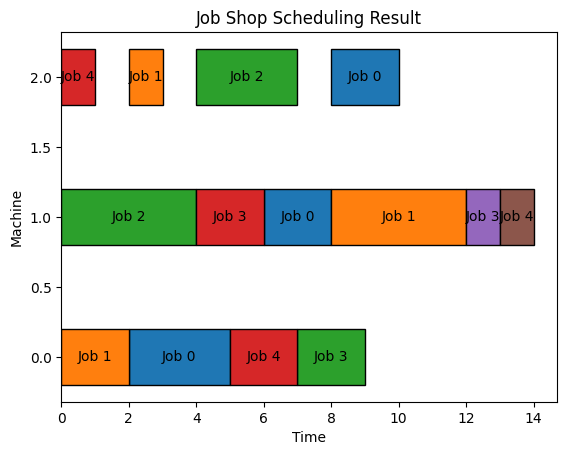

In [8]:
# 結果の解析とグラフ用のデータの作成
machines_schedule = {m: [] for m in range(num_machines)}
for job_id, job in enumerate(jobs_data):
    for task_id, task in enumerate(job):
        machine = task[0]
        start = solver.Value(tasks[job_id, task_id][0])
        end = solver.Value(tasks[job_id, task_id][1])
        machines_schedule[machine].append((start, end, f'Job {job_id}'))

# グラフの描画
fig, ax = plt.subplots()
colors = list(mcolors.TABLEAU_COLORS.values())  # カラーパレット
for machine, machine_schedule in machines_schedule.items():
    for job_num, (start, end, job_label) in enumerate(machine_schedule):
        ax.barh(machine, end - start, left=start, height=0.4, color=colors[job_num % len(colors)], edgecolor='black')
        ax.text((start + end) / 2, machine, job_label, ha='center', va='center')

ax.set_xlabel('Time')
ax.set_ylabel('Machine')
ax.set_title('Job Shop Scheduling Result')
plt.show()

## 重みをつけた場合

1. ジョブの優先度: [100, 2, 1, 10, 30]
ジョブ 0 タスク 0 開始: 0, 終了: 3
ジョブ 0 タスク 1 開始: 3, 終了: 5
ジョブ 0 タスク 2 開始: 5, 終了: 7
ジョブ 1 タスク 0 開始: 7, 終了: 9
ジョブ 1 タスク 1 開始: 9, 終了: 10
ジョブ 1 タスク 2 開始: 12, 終了: 16
ジョブ 2 タスク 0 開始: 8, 終了: 12
ジョブ 2 タスク 1 開始: 12, 終了: 15
ジョブ 3 タスク 0 開始: 0, 終了: 2
ジョブ 3 タスク 1 開始: 5, 終了: 7
ジョブ 3 タスク 2 開始: 7, 終了: 8
ジョブ 4 タスク 0 開始: 0, 終了: 1
ジョブ 4 タスク 1 開始: 3, 終了: 5
ジョブ 4 タスク 2 開始: 5, 終了: 6


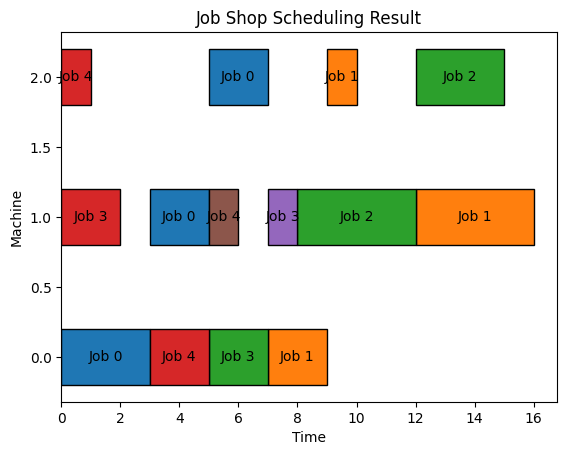

2. ジョブの優先度: [100, 2, 1, 10, 30]
ジョブ 0 タスク 0 開始: 0, 終了: 3
ジョブ 0 タスク 1 開始: 3, 終了: 5
ジョブ 0 タスク 2 開始: 5, 終了: 7
ジョブ 1 タスク 0 開始: 7, 終了: 9
ジョブ 1 タスク 1 開始: 9, 終了: 10
ジョブ 1 タスク 2 開始: 12, 終了: 16
ジョブ 2 タスク 0 開始: 8, 終了: 12
ジョブ 2 タスク 1 開始: 12, 終了: 15
ジョブ 3 タスク 0 開始: 0, 終了: 2
ジョブ 3 タスク 1 開始: 5, 終了: 7
ジョブ 3 タスク 2 開始: 7, 終了: 8
ジョブ 4 タスク 0 開始: 0, 終了: 1
ジョブ 4 タスク 1 開始: 3, 終了: 5
ジョブ 4 タスク 2 開始: 5, 終了: 6


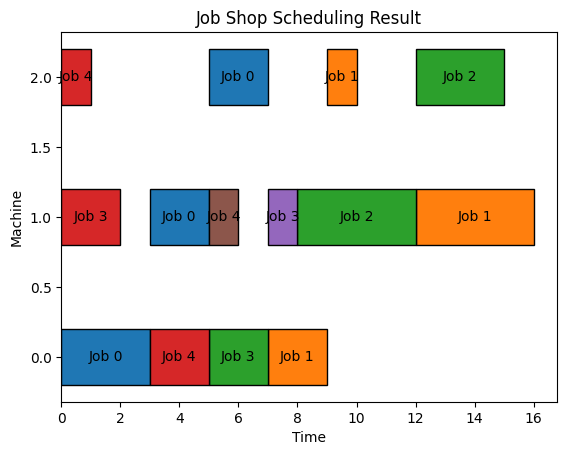

3. ジョブの優先度: [100, 2, 1, 10, 30]
ジョブ 0 タスク 0 開始: 0, 終了: 3
ジョブ 0 タスク 1 開始: 3, 終了: 5
ジョブ 0 タスク 2 開始: 5, 終了: 7
ジョブ 1 タスク 0 開始: 7, 終了: 9
ジョブ 1 タスク 1 開始: 9, 終了: 10
ジョブ 1 タスク 2 開始: 12, 終了: 16
ジョブ 2 タスク 0 開始: 8, 終了: 12
ジョブ 2 タスク 1 開始: 12, 終了: 15
ジョブ 3 タスク 0 開始: 0, 終了: 2
ジョブ 3 タスク 1 開始: 5, 終了: 7
ジョブ 3 タスク 2 開始: 7, 終了: 8
ジョブ 4 タスク 0 開始: 0, 終了: 1
ジョブ 4 タスク 1 開始: 3, 終了: 5
ジョブ 4 タスク 2 開始: 5, 終了: 6


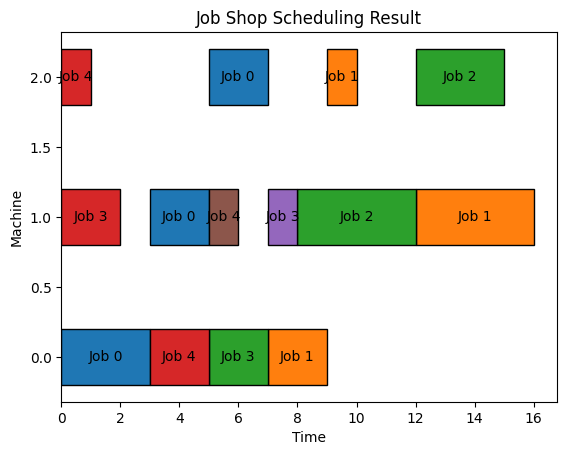

In [9]:
jobs_data = [
    [(0, 3), (1, 2), (2, 2)],
    [(0, 2), (2, 1), (1, 4)],
    [(1, 4), (2, 3)],
    [(1, 2), (0, 2), (1, 1)],
    [(2, 1), (0, 2), (1, 1)],
]

job_priorities_list = [
    [100, 2, 1, 10, 30],
    [100, 2, 1, 10, 30],
    [100, 2, 1, 10, 30],
]

for i in range(3):

    # ジョブの優先度（高い数値が高い優先度）
    # [100, 2, 1] などにすることで最優先のようにすることも可能
    job_priorities = job_priorities_list[i]
    print(f"{i+1}. ジョブの優先度: {job_priorities}")

    # モデルとソルバーの初期化
    model = cp_model.CpModel()

    # 変数と制約の定義
    tasks = {}
    ends = []
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine, duration = task
            start_var = model.NewIntVar(0, 1000, f'start_{job_id}_{task_id}')
            end_var = model.NewIntVar(0, 1000, f'end_{job_id}_{task_id}')
            interval_var = model.NewIntervalVar(start_var, duration, end_var, f'interval_{job_id}_{task_id}')
            tasks[job_id, task_id] = (start_var, end_var, interval_var)
            if task_id == len(job) - 1:
                ends.append(end_var)

    # 同一機械での非重複制約
    machines = {i: [] for i in range(3)}
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine, _ = task
            machines[machine].append(tasks[job_id, task_id][2])
    for machine_intervals in machines.values():
        model.AddNoOverlap(machine_intervals)

    # 同一ジョブ内の順序制約
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(tasks[job_id, task_id][1] <= tasks[job_id, task_id + 1][0])

    # 目的関数（優先度に応じたペナルティを含む完了時間の最小化）
    weighted_ends = [end * job_priorities[job_id] for job_id, end in enumerate(ends)]
    model.Minimize(sum(weighted_ends))

    # ソルバーの実行
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    # 結果の出力
    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                start = solver.Value(tasks[job_id, task_id][0])
                end = solver.Value(tasks[job_id, task_id][1])
                print(f'ジョブ {job_id} タスク {task_id} 開始: {start}, 終了: {end}')
    else:
        print('最適解が見つかりませんでした。')

    # 結果の解析とグラフ用のデータの作成
    machines_schedule = {m: [] for m in range(num_machines)}
    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            start = solver.Value(tasks[job_id, task_id][0])
            end = solver.Value(tasks[job_id, task_id][1])
            machines_schedule[machine].append((start, end, f'Job {job_id}'))

    # グラフの描画
    fig, ax = plt.subplots()
    colors = list(mcolors.TABLEAU_COLORS.values())  # カラーパレット
    for machine, machine_schedule in machines_schedule.items():
        for job_num, (start, end, job_label) in enumerate(machine_schedule):
            ax.barh(machine, end - start, left=start, height=0.4, color=colors[job_num % len(colors)], edgecolor='black')
            ax.text((start + end) / 2, machine, job_label, ha='center', va='center')

    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Job Shop Scheduling Result')
    plt.show()


## 好きなジョブパターン

ジョブ 0 タスク 0 開始: 4, 終了: 7
ジョブ 0 タスク 1 開始: 7, 終了: 9
ジョブ 0 タスク 2 開始: 9, 終了: 11
ジョブ 1 タスク 0 開始: 10, 終了: 12
ジョブ 1 タスク 1 開始: 14, 終了: 15
ジョブ 1 タスク 2 開始: 20, 終了: 24
ジョブ 2 タスク 0 開始: 26, 終了: 30
ジョブ 2 タスク 1 開始: 30, 終了: 33
ジョブ 3 タスク 0 開始: 11, 終了: 13
ジョブ 3 タスク 1 開始: 13, 終了: 15
ジョブ 3 タスク 2 開始: 15, 終了: 16
ジョブ 4 タスク 0 開始: 0, 終了: 1
ジョブ 4 タスク 1 開始: 1, 終了: 3
ジョブ 4 タスク 2 開始: 3, 終了: 4
ジョブ 5 タスク 0 開始: 0, 終了: 1
ジョブ 5 タスク 1 開始: 1, 終了: 3
ジョブ 5 タスク 2 開始: 3, 終了: 6
ジョブ 6 タスク 0 開始: 15, 終了: 16
ジョブ 6 タスク 1 開始: 18, 終了: 20
ジョブ 6 タスク 2 開始: 21, 終了: 24
ジョブ 7 タスク 0 開始: 8, 終了: 9
ジョブ 7 タスク 1 開始: 24, 終了: 26
ジョブ 7 タスク 2 開始: 26, 終了: 29
ジョブ 8 タスク 0 開始: 12, 終了: 13
ジョブ 8 タスク 1 開始: 13, 終了: 15
ジョブ 8 タスク 2 開始: 15, 終了: 18
ジョブ 9 タスク 0 開始: 7, 終了: 8
ジョブ 9 タスク 1 開始: 9, 終了: 11
ジョブ 9 タスク 2 開始: 11, 終了: 14
ジョブ 10 タスク 0 開始: 3, 終了: 4
ジョブ 10 タスク 1 開始: 4, 終了: 6
ジョブ 10 タスク 2 開始: 6, 終了: 9
ジョブ 11 タスク 0 開始: 9, 終了: 10
ジョブ 11 タスク 1 開始: 16, 終了: 18
ジョブ 11 タスク 2 開始: 18, 終了: 21


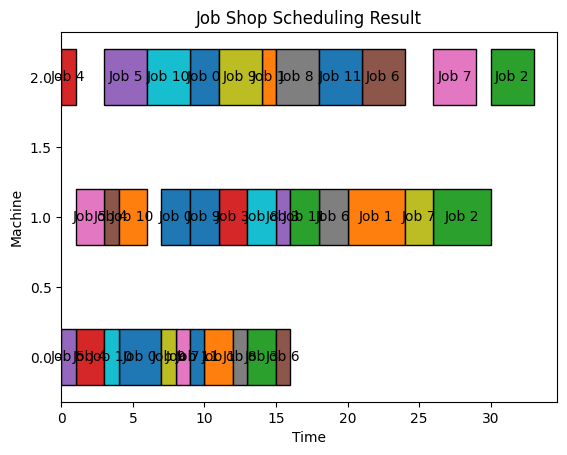

In [10]:
jobs_data = [
    [(0, 3), (1, 2), (2, 2)],
    [(0, 2), (2, 1), (1, 4)],
    [(1, 4), (2, 3)],
    [(1, 2), (0, 2), (1, 1)],
    [(2, 1), (0, 2), (1, 1)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
    [(0, 1), (1, 2), (2, 3)],
]

job_priorities = [100, 2, 1, 10, 30, 100, 2, 1, 10, 30, 100, 2]
num_machines = 12

opt_orTools.opt_orTools(jobs_data, job_priorities, num_machines)